In [12]:
import torch
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
from torchvision import transforms

from diffusers import DDPMPipeline

import datasets
from datasets import load_dataset

from utils.motionblur import Kernel
from utils.utils_img import fft_blur, clean_output, tensor2uint, clamp
from utils.scheduler import NewDDPMScheduler, NewDDPMSchedulerOutput, alpha_beta, scheduler_alpha_t, scheduler_alphas

from conditional_sampling import dps_sampling_batch, dps_sampling, tds_sampling_batch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import os
cache_dir = '/Data/dheurtel/cache'

In [13]:
tracing = False
half = True

if half:
    torch.set_default_tensor_type(torch.HalfTensor)

model_name="google/ddpm-ema-celebahq-256" # 256x256 8 iteratons/second
model_name="basilevh/ddpm-ema-flowers-256-noac"

ddpm = DDPMPipeline.from_pretrained(model_name, cache_dir=cache_dir,torch_dtype=torch.float16).to(device)
ddpm.unet = ddpm.unet.eval()

datasets.config.DOWNLOADED_DATASETS_PATH = Path("/Data/datasets")
dataset = load_dataset("huggan/flowers-102-categories", cache_dir=cache_dir, split="train")

checkpoint-11000/model.safetensors not found
Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]


100%|██████████| 200/200 [00:04<00:00, 40.55it/s]


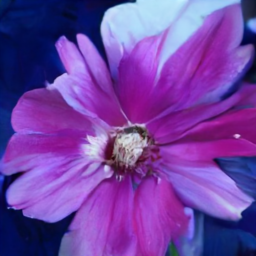

In [14]:
image = ddpm(num_inference_steps=200).images[0]
image

In [15]:
initial_scheduler = ddpm.scheduler
new_scheduler = NewDDPMScheduler(**initial_scheduler.config)

num_time_steps = 500

new_scheduler.set_timesteps(num_time_steps)

model = ddpm.unet
model.scheduler = new_scheduler

(-0.5, 14.5, 14.5, -0.5)

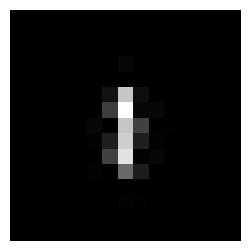

In [16]:
kernel = Kernel(size=(15,15), intensity=0.5)
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.imshow(kernel.kernelMatrix, cmap='gray')
ax.axis('off')

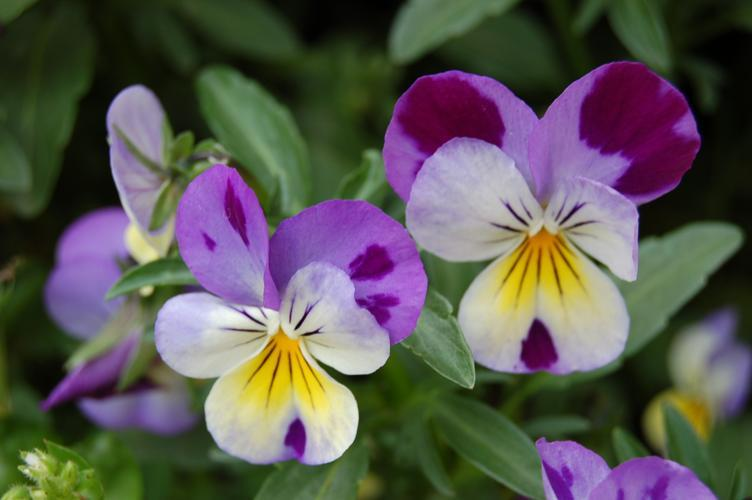

In [17]:
## Img from PIL to torch
pil_img = dataset[0]["image"]
pil_img

In [18]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

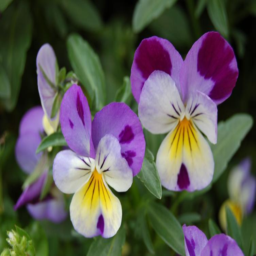

In [19]:
img = transform(pil_img)
img.shape

pil_img = transforms.ToPILImage()(img)
pil_img

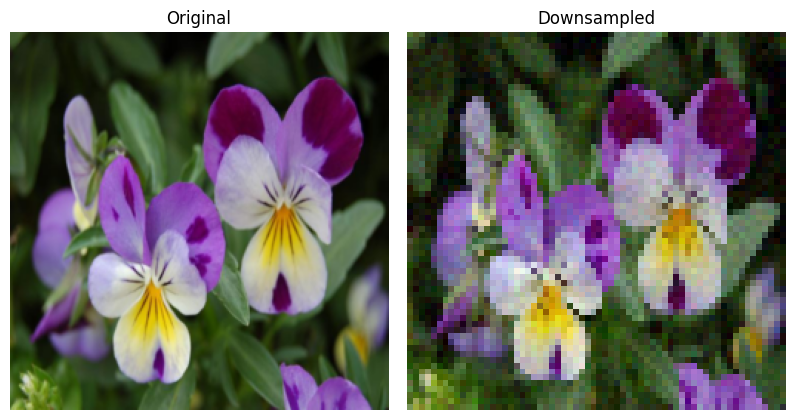

In [20]:
degradation = "super_resolution" #"motion_blur"
sr_factor = 1/4
sigma_y_sr = 0.03
sigma_y = 0.06
save_fig = False

if degradation == "motion_blur":
    k = torch.tensor(kernel.kernelMatrix)
    forward_model = lambda x: fft_blur(x.to(torch.float32), k.unsqueeze(0).unsqueeze(0).to(x.device)).to(x.dtype)
    observation = forward_model(img)
    observation+= torch.randn_like(observation) * sigma_y
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(tensor2uint(img))
    ax[1].imshow(tensor2uint(clamp(observation, 0, 1)))
    ax[0].set_title("Original")
    ax[1].set_title("Blurred")
    ax[0].axis('off')
    ax[1].axis('off')
    plt.subplots_adjust(wspace=0.05)
    if save_fig:
        plt.savefig("./figures/motion_blur.pdf", bbox_inches='tight')
    plt.show()
elif degradation == "super_resolution":
    def forward_model(x):
        if len(x.shape) == 2:
            x = x.unsqueeze(0).unsqueeze(0)
            return torch.nn.functional.interpolate(x.to(torch.float32), scale_factor=sr_factor, mode='bilinear', align_corners=True).to(x.dtype).squeeze(0).squeeze(0)
        elif len(x.shape) == 3:
            x = x.unsqueeze(0)
            return torch.nn.functional.interpolate(x.to(torch.float32), scale_factor=sr_factor, mode='bilinear', align_corners=True).to(x.dtype).squeeze(0)
        elif len(x.shape) == 4:
            return torch.nn.functional.interpolate(x.to(torch.float32), scale_factor=sr_factor, mode='bilinear', align_corners=True).to(x.dtype)
    observation = forward_model(img) 
    observation+= torch.randn_like(observation) * sigma_y_sr
    fig, ax = plt.subplots(1, 2, figsize=(10, 7))
    ax[0].imshow(tensor2uint(img))
    ax[1].imshow(tensor2uint(clamp(observation, 0, 1)))
    ax[0].set_title("Original")
    ax[1].set_title("Downsampled")
    ax[0].axis('off')
    ax[1].axis('off')
    # Set horizontal spacing between subplots
    plt.subplots_adjust(wspace=0.05)
    if save_fig:
        plt.savefig("./figures/super_resolution.pdf", bbox_inches='tight')

In [21]:
def forward_log_likelihood(x, y, rescaling_factor):
    ndim = y.shape[1:].numel()
    return - torch.sum((forward_model(x)-y)**2, dim=(1,2,3)),2*(sigma_y**2+rescaling_factor) ,- np.log(sigma_y**2+rescaling_factor)*ndim/2

## In half precision, returning separately the quadratic form, the variance term and the log factor helps with numerical stability. They are only combined when needed

## DPS

In [26]:
model = model.to(device)
nsamples = 8

In [32]:
res = dps_sampling(model, nsamples, observation.to(device), forward_log_likelihood, new_scheduler, verbose = True, eta=4.0,time_rescaling=True, display_intermediary=False)
# Play with the eta parameter to see how it impacts the sampling (higher eta means more guidance, lower eta means more exploration)
#  4.... for the value of the jacobian of the forward model, see our report and the link between our proposal and the PiGDM technique
#  But try 3, 10, 1...

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [01:59<00:00,  4.17it/s]


In [33]:
#res = dps_sampling_batch(model, 32, blurry_img.to(device), forward_log_likelihood, scheduler, verbose = True, eta=1.0,time_rescaling=True, display_intermediary=False, batch_size=16)

**Remark** This implementation computes most quantities in a batched manner, with some memory manipulations (clone, detach that clears the computation graph) to limit memory usage. All these quantities could be computed in parallel on several GPUs. That being said on a single GPU, like ours, quick profiling shows that the bottleneck of computations is not these memory manipulations but the sheer number of FLOPs required by the foward and backward passes in the network.

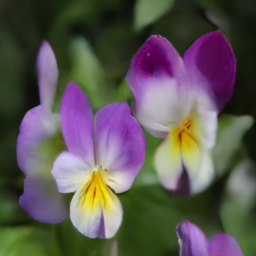

In [34]:
pil_res = transforms.ToPILImage()(res[0])
pil_res

## TDS

In [35]:
nsamples = 60
batch_size = 20

In [40]:
## Eta schedule in three parts
## linear from 0.05 to 0.01 in 100 steps
## constant at 0.01 for 50 step
## linear from 0.01 to 1 in 50 steps

eta_schedule = torch.cat([torch.linspace(0.1, 1, 300), torch.linspace(1, 3, 200)])
eta_schedule = eta_schedule*(degradation == "super_resolution")*4 + eta_schedule*(degradation == "motion_blur")
#eta_schedule = torch.linspace(0.03, 0.5, len(new_scheduler.timesteps))
#eta_schedule = torch.cat([torch.ones(40)*0.4, torch.linspace(0.04, 0.1, 80), torch.ones(80)*0.1])
eta_schedule = eta_schedule.numpy()

  0%|          | 0/499 [00:00<?, ?it/s]

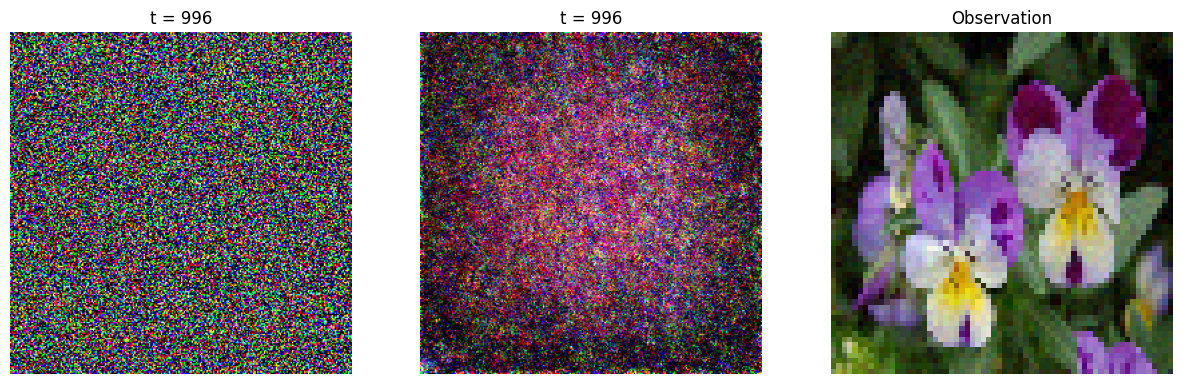

 25%|██▍       | 124/499 [04:25<13:22,  2.14s/it]

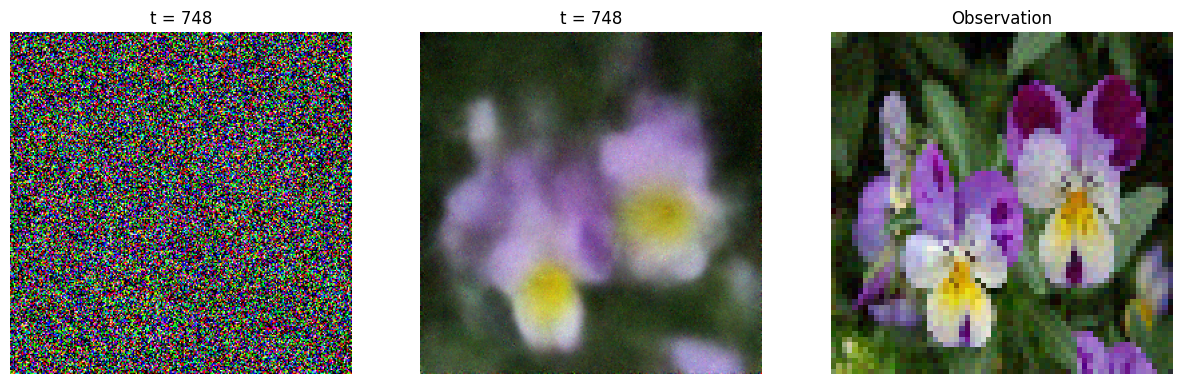

 50%|████▉     | 249/499 [08:52<08:55,  2.14s/it]

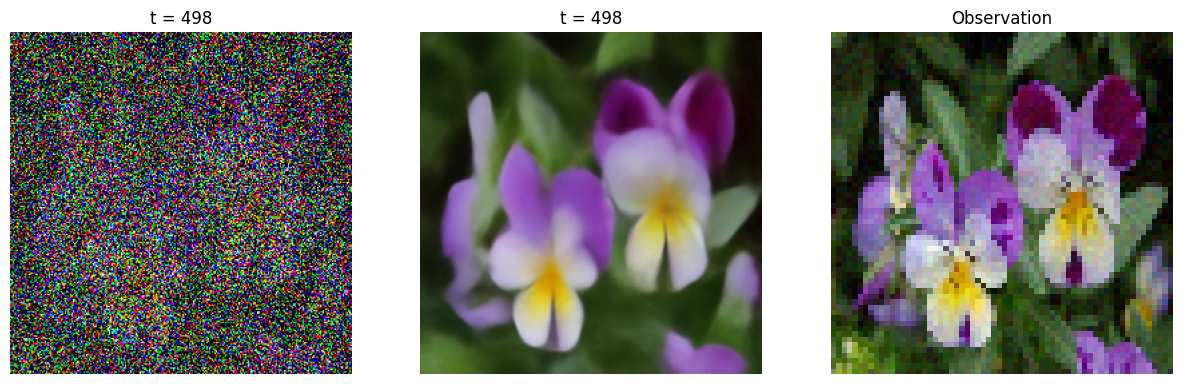

 75%|███████▍  | 374/499 [13:20<04:27,  2.14s/it]

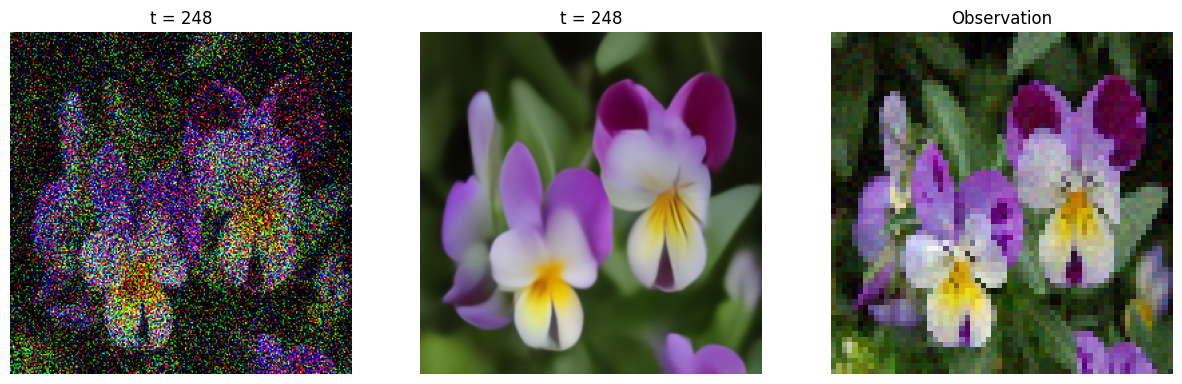

100%|██████████| 499/499 [17:48<00:00,  2.14s/it]


In [41]:
#eta_schedule = None
res, ess_list = tds_sampling_batch(model, nsamples, observation.to(device), forward_log_likelihood, new_scheduler, verbose = True, eta=0.4,time_rescaling=True,
                      batch_size=batch_size,threshold_resampling = 0.9, return_auxiliary = True, eta_schedule = eta_schedule)

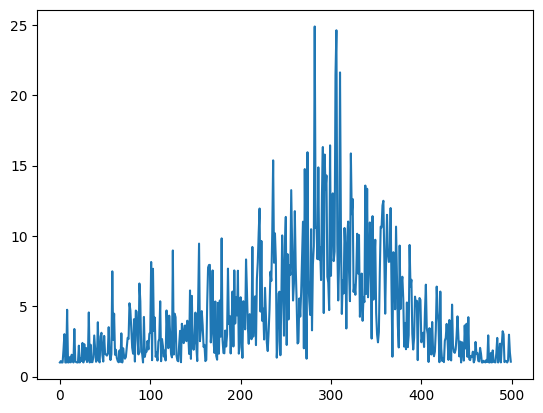

In [42]:
plt.plot(ess_list)

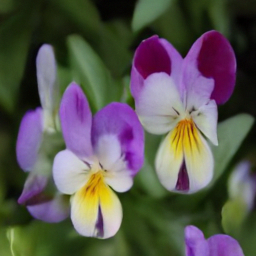

In [43]:
pil_res = transforms.ToPILImage()(res[0])
pil_res

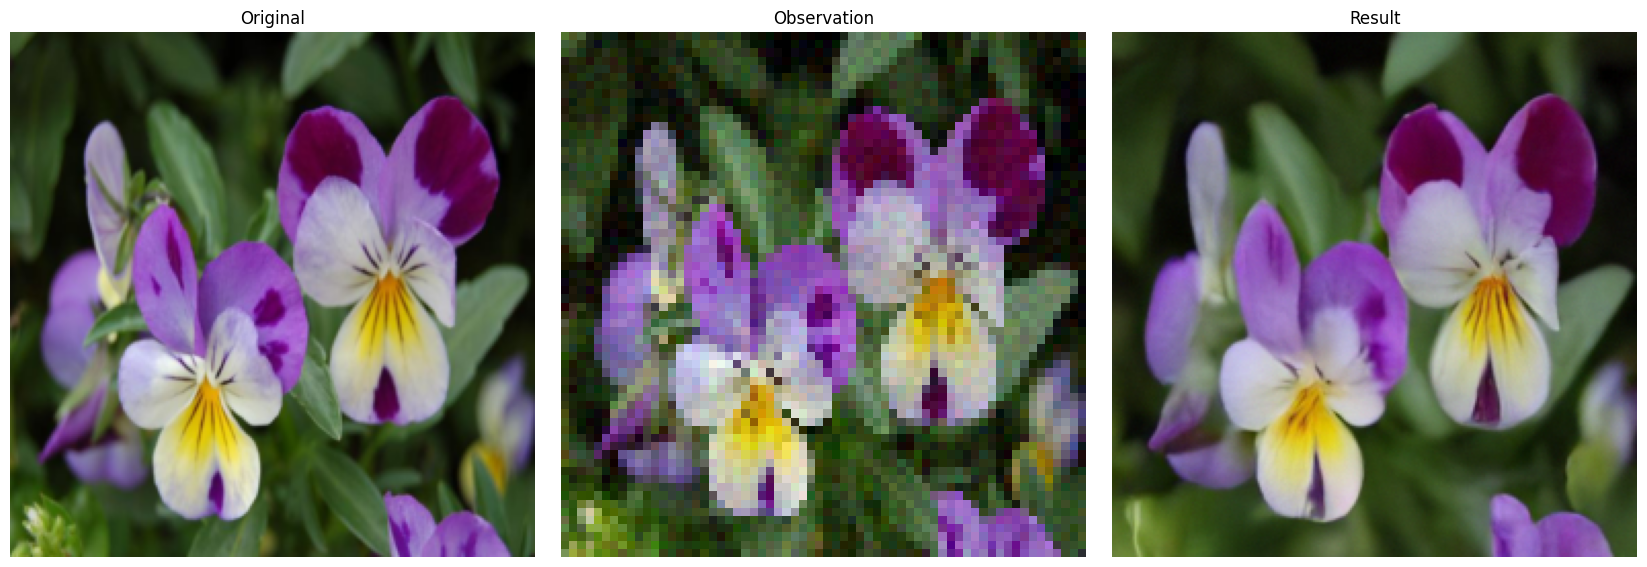

In [47]:
## Figure with base image, observation and result and ess
save_fig = True
fig, ax = plt.subplots(1, 3, figsize=(21, 7))
ax[0].imshow(tensor2uint(img))
ax[1].imshow(tensor2uint(clamp(observation, 0, 1)))
ax[2].imshow(tensor2uint(clamp(res[0], 0, 1)))
ax[0].set_title("Original")
ax[1].set_title("Observation")
ax[2].set_title("Result")
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.subplots_adjust(wspace=0.05)
if save_fig:
    plt.savefig("./figures/tds_sampling.pdf", bbox_inches='tight')